# Watershed
The watershed algorithm is basically a region growing (seed-based) method.
To start we need to define markers that we know are in each of the regions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# I'll use this later to draw the memberships of the groups 
from matplotlib.colors import ListedColormap

In [2]:
# Let's use the Cathedral of Learning image for this
im = cv2.imread(os.path.relpath('../../Data/Pitt_Cathedral.jpg'), cv2.IMREAD_COLOR)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

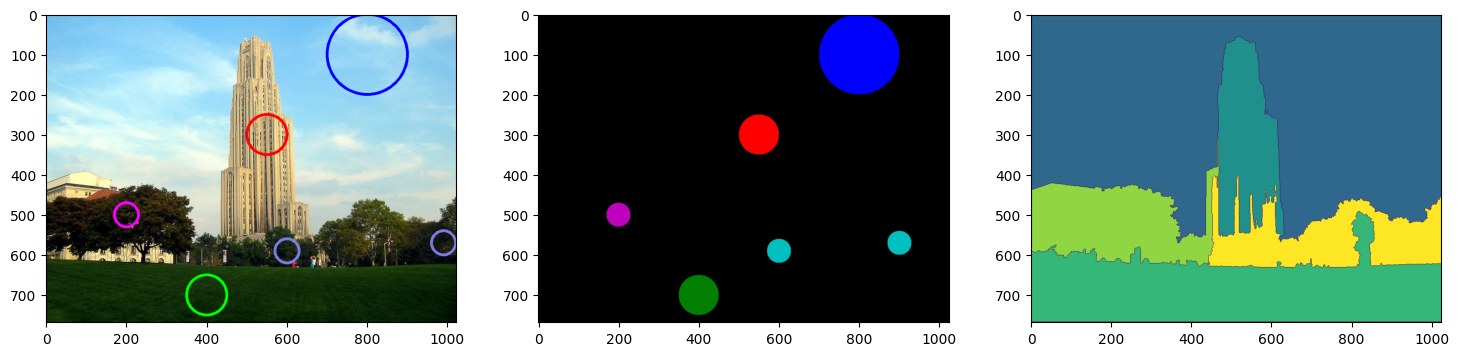

In [3]:
# Let's manually find some points of interest on our image

imagelabeled = im.copy()  # I'll use this to show the annotations

markers = np.zeros((im.shape[0],im.shape[1]),dtype='int32') # but, this is our actual marker image

cv2.circle(imagelabeled, (800,100), 100, (0, 0, 255), thickness=5)
cv2.circle(imagelabeled, (550,300), 50, (255, 0, 0), thickness=5)
cv2.circle(imagelabeled, (400,700), 50, (0, 255, 0), thickness=5)
cv2.circle(imagelabeled, (200,500), 30, (255,0,255), thickness=5)
cv2.circle(imagelabeled, (200,500), 30, (255,0,255), thickness=5)
cv2.circle(imagelabeled, (990,570), 30, (125,125,225), thickness=5)
cv2.circle(imagelabeled, (600,590), 30, (125,125,225), thickness=5)

# Do the same four regions in the mask, giving them unique IDs and filled circles
cv2.circle(markers, (800,100), 100, 1, thickness=-1)
cv2.circle(markers, (550,300), 50, 2, thickness=-1)
cv2.circle(markers, (400,700), 50, 3, thickness=-1)
cv2.circle(markers, (200,500), 30, 4, thickness=-1)
cv2.circle(markers, (900,570), 30, 5, thickness=-1)
cv2.circle(markers, (600,590), 30, 5, thickness=-1)

# Do seed growing from those markers
markersWS = cv2.watershed(im,markers.copy())

# Display the image
plt.figure(figsize=[18, 5])

from matplotlib.colors import ListedColormap
plt.subplot(131); plt.imshow(imagelabeled)
plt.subplot(132); plt.imshow(markers,cmap=ListedColormap(['k','b','r','g','m','c']))
plt.subplot(133); plt.imshow(markersWS)



## Watershed from detected regions

In [4]:
im = cv2.imread(os.path.relpath('../../Data/Coins.png'), cv2.IMREAD_COLOR)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
imgray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

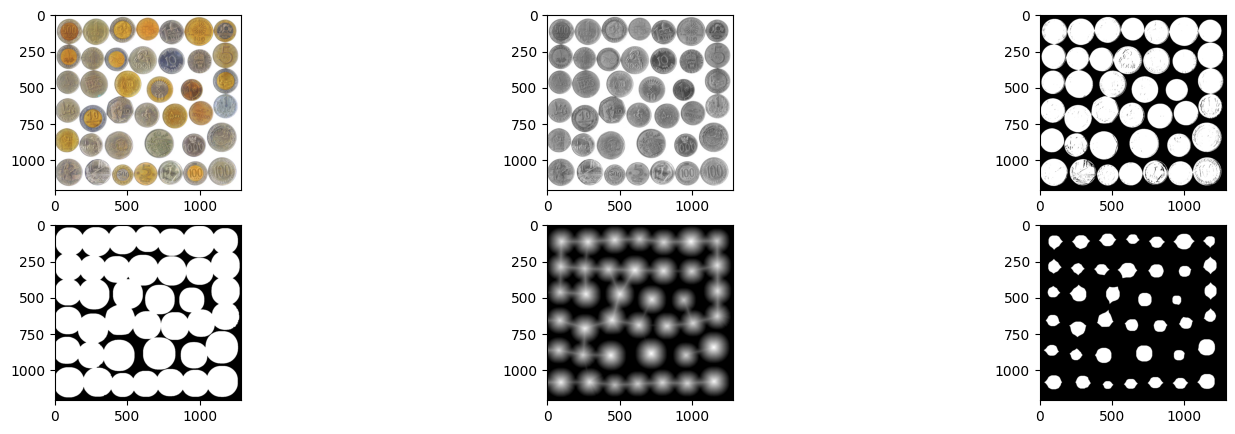

In [5]:
#Threshold Processing

_, imbin = cv2.threshold(imgray,0, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel=np.ones((5,5))
imbin_dil=cv2.dilate(imbin,kernel,iterations=5) 

# Distance transform
# This computes the distance from each white point to the nearest black.  The higher the number, the more in the center of the coin it is
dist = cv2.distanceTransform(imbin_dil, cv2.DIST_L2, 5)

_, coin_centers = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
coin_centers = np.uint8(coin_centers)

plt.figure(figsize=[18, 5])
plt.subplot(231); plt.imshow(im)
plt.subplot(232); plt.imshow(imgray,cmap='gray')
plt.subplot(233); plt.imshow(imbin,cmap='gray')
plt.subplot(234); plt.imshow(imbin_dil,cmap='gray')
plt.subplot(235); plt.imshow(dist,cmap='gray')
plt.subplot(236); plt.imshow(coin_centers,cmap='gray')



In [6]:
# Now that we have the centers of the coins, we can seperate them into individual labels

_,markers = cv2.connectedComponents(coin_centers)

# The markers go from 1-40 with both the background and the parts of the coins not labeled as "0"
# We need to add a marker for the background as well, which we will use index 1 and shift everyone else up


markers+=1
markers[cv2.bitwise_and(cv2.bitwise_not(coin_centers),imbin_dil)==255]=0  # zero denotes unknown

# Do seed growing from those markers
markersWS = cv2.watershed(im,markers.copy())

# Use the expanded markers to mask out all the coins. (index=1 is our background, so first remove that)
_, markerMaskAll = cv2.threshold(np.uint8(markersWS),1,255,cv2.THRESH_BINARY)
im_masked = cv2.bitwise_and(im,im,mask=markerMaskAll)




# Some of the coins are still cut off, lets do this for a second iteration
# Now that our markers are better placed, we can unassign (set to 0) the bad areas and try again
markersWS2=markersWS.copy()
markersWS2[cv2.bitwise_and(cv2.bitwise_not(markerMaskAll),imbin_dil)==255]=0  # zero denotes unknown
markersWS2 = cv2.watershed(im,markersWS2)

_, markerMaskAll2 = cv2.threshold(np.uint8(markersWS2),1,255,cv2.THRESH_BINARY)
im_masked2 = cv2.bitwise_and(im,im,mask=markerMaskAll2)

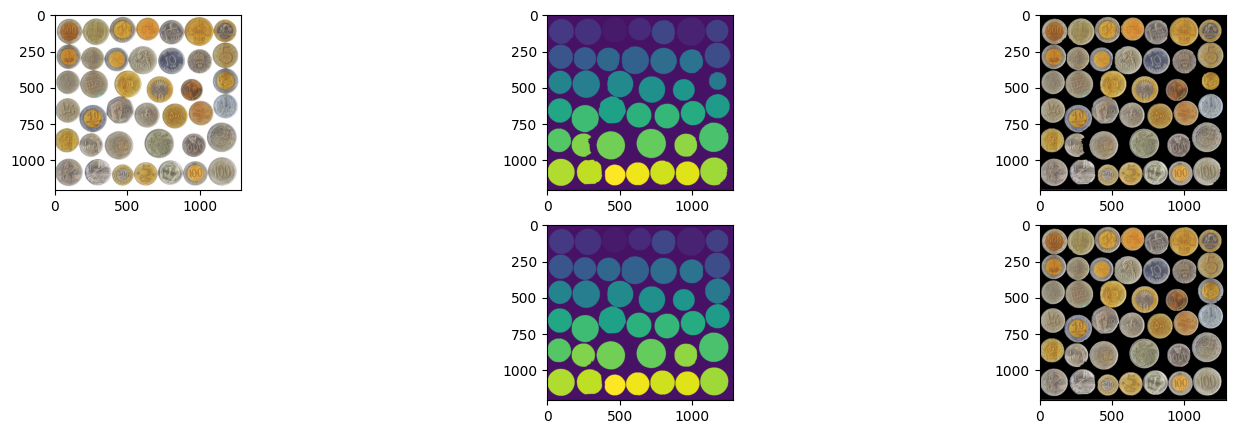

In [7]:
plt.figure(figsize=[18, 5])
plt.subplot(231); plt.imshow(im)
plt.subplot(232); plt.imshow(markersWS)
plt.subplot(233); plt.imshow(im_masked)
plt.subplot(235); plt.imshow(markersWS2)
plt.subplot(236); plt.imshow(im_masked2)
